In [20]:
import os
import dotenv
dotenv.load_dotenv()
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
neon_db_url = os.environ.get("NEON_DB_CONSTR")
import pandas as pd

In [21]:
def plot_entry_data(row, engine):
    _price = pd.read_sql(f'select * from stock_data where stock_data.stock_id = {row.stock_id}', engine)
    _price['cost'] = row.cost
    _price['stop'] = row.stop 
    _price['target'] = row.target 
    _price['trail'] = row.trail 
    _price['m_close'] = _price['close']
    _price[['m_close', 'target', 'trail', 'cost', 'stop']].iloc[-100:].plot(
        color=['black', 'green', 'orange', 'blue', 'red'],
        title=row.symbol
    )

In [22]:
engine = create_engine(neon_db_url)

In [23]:
entries = pd.read_sql_table('entry', engine)

In [26]:
symbol = 'PCAR'
relative = True

entry_query = (
    (entries.symbol == symbol) &
    (entries.is_relative == relative)
)

entries.loc[entry_query]

,entry_date,symbol,cost,stop,trail,trail_amount,target,quantity,direction,risk,multiple,fraction,is_relative,stock_id,signal_age,r_pct
886,2024-05-24,PCAR,206.690087,197.302183,203.554213,3.057683,211.384039,53.260022,1,500,1,0.666667,True,895,10,0.04542


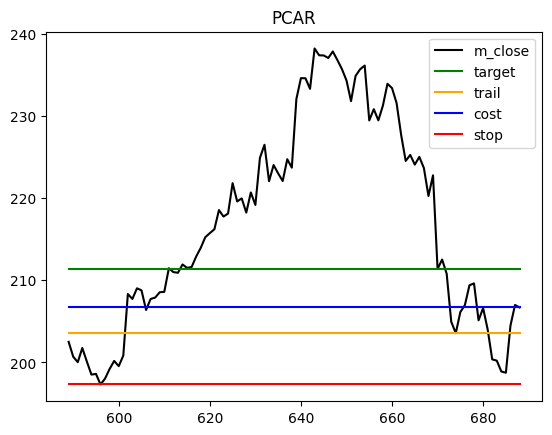

In [27]:
plot_entry_data(entries.loc[entry_query].iloc[0], engine)

In [5]:
_positions = pd.read_excel('..\positions.xlsx', index_col=0)
_positions = _positions.loc[_positions.active == True]


FileNotFoundError: [Errno 2] No such file or directory: '..\\positions.xlsx'

In [ ]:

def updated_positions(positions):
    with Session(engine) as session:
        records = [udp.PositionManager.from_row(session, row).as_dict() for i, row in positions.iterrows()]
    
    table = pd.DataFrame.from_records(records).reset_index().rename(columns={'index': 'id'})
    return table

def get_stops_triggered(positions):
    trail_triggered = ((positions.price - positions.trail) * positions.direction) < 0
    stop_triggered = ((positions.price - positions.stop) * positions.direction) < 0
    regime_triggered = positions.regime != positions.direction
    
    positions['stop_triggered'] = stop_triggered
    positions['trail_triggered'] = trail_triggered
    positions['regime_triggered'] = regime_triggered
    return positions.loc[trail_triggered | stop_triggered | regime_triggered].copy()


def get_target_triggered(positions):
    target_triggered = ((positions.price - positions.target) * positions.direction) >= 0
    return positions.loc[target_triggered].copy()



def plot_current_position_data(positions):
    for i, row in positions.iterrows():
        _price = pd.read_sql(f'select * from stock_data where stock_data.stock_id = {row.stock_id}', engine)
        _price['cost'] = row.cost
        _price['stop'] = row.stop 
        _price['target'] = row.target 
        _price['trail'] = row.trail 
        _price['m_close'] = _price['close']
        _price[['m_close', 'target', 'trail', 'cost', 'stop']].iloc[-100:].plot(
            color=['black', 'green', 'orange', 'blue', 'red'],
            title=row.symbol
        )
            

In [ ]:
current_position_data = updated_positions(_positions)

In [ ]:
stops_triggered = get_stops_triggered(current_position_data)
stops_triggered

,id,entry_date,symbol,is_relative,cost,stop,trail,price,trail_amount,target,quantity,direction,risk,multiple,fraction,stock_id,regime,stop_triggered,trail_triggered,regime_triggered
1,1,2023-12-20,XLF,True,78.929625,77.423181,79.920978,78.572757,0.792012,79.682847,300,1,1000,1,0.666667,25,1.0,False,True,False


In [ ]:
_target_triggered = get_target_triggered(current_position_data)
_target_triggered

,id,entry_date,symbol,is_relative,cost,stop,trail,price,trail_amount,target,quantity,direction,risk,multiple,fraction,stock_id,regime,stop_triggered,trail_triggered,regime_triggered
0,0,2023-12-01,XLE,True,184.39,215.196,172.06477,165.53377,6.531,168.984,-100,-1,1000,1,0.666667,24,-1.0,False,False,False


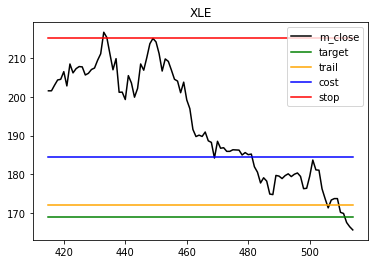

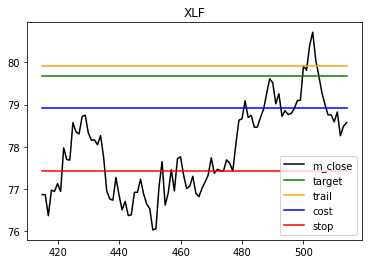

In [ ]:
plot_current_position_data(current_position_data)

In [ ]:
relative_entries = entries.loc[
    (entries.is_relative == True)
    & (entries.signal_age > 0)
]
absolute_entries = entries.loc[
    (entries.is_relative == False)
    & (entries.signal_age > 0)
]

In [ ]:
relative_entries.loc[relative_entries.symbol == 'XLF']

,entry_date,symbol,cost,stop,trail,trail_amount,target,quantity,direction,risk,multiple,fraction,is_relative,stock_id,signal_age,r_pct
20,2024-01-22,XLF,78.572757,78.46305,78.723359,0.062991,78.62761,4557.599477,1,500,1,0.666667,True,25,18,0.001396
